This notebook contains example code for running the pingpong table demo shown in Figure-9 of the main paper. 

The example code will load the video with 5 hits in `data/pingpong_demo/oct15_5bounce/`

# Load libraries

In [1]:
from src.tilt_signal import Tilt2D, AngleMapping

from src.plot_utils import plot_signals, color_mapping

from src.data_utils import  load_from_processed, load_npz_array_dict

from src.opencv_video_helper import videoPlayer, read_mov

from src.backproj_solver import BackProjSolver
import copy
import os
import cv2

import numpy as np
# import imageio 
import skimage
import hdf5pickle
import os
import json

%matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# simple helper function for plot a list
def plot_list_func(y_list, label_list=None):
    
    x_list = list(range(len(y_list[0])))
    
    plt.figure()
    for i, y in enumerate(y_list):
        if label_list is not None:
            plt.plot(x_list, y, label=label_list[i])
        else:
            plt.plot(x_list, y)
            
    if label_list is not None:
        plt.legend()
    plt.show()


## Additional defined functions

In [2]:
def _load_data(data_path, optical_scaling=1.0, len_first_clip=150):
    
    remove_list = [
        [], 

    ]
    
    data = hdf5pickle.load(data_path)
    # data = hdf5pickle.load('./data/prop_model/whiteboard_metal_ball_near_edge.hdf5')
    x_meas_vec = np.array(data['x_meas_vec']) # [N, num_mark, num_frame, num_row]. if num_frame = 1, it is collapsed 
    y_meas_vec = np.array(data['y_meas_vec']) / optical_scaling
    data_points = np.array(data['data_points'])
    print(data_points)
    
    signal_list_list = []
    name_list = []
    gt_locations_list = []
    
    for i in range(len(data_points)):
        
        
        name = data_points[i]
        
        name_list.append(name)
        signal_list = []
        for j in range(5):
            if x_meas_vec[i][j].ndim > 1:
                signal_list.append(Tilt2D([x_meas_vec[i][j].flatten(), y_meas_vec[i][j].flatten()], len_first_clip=len_first_clip))
            else:
                signal_list.append(Tilt2D([x_meas_vec[i][j], y_meas_vec[i][j]], len_first_clip=len_first_clip))
               
        signal_list_list.append(signal_list)
        
    print(name_list)
    return signal_list_list, name_list

# Load data

In [3]:
dir_name = "data/pingpong_demo/oct15_5bounce/"
dir_path = dir_name
video_path = os.path.join(dir_name, "video.MOV")
ann_path = os.path.join(dir_name, "video_annotate.npz")
hdf5_path = os.path.join(dir_name, "measurements_data.hdf5")
caliberation_path = os.path.join(dir_name, "camera_caliberation.json")

# 'hit_frames', 'warpped_hit_frames', 'homo_M', 'homo_rawxy', 'homo_tgtxy'
ann_dict = load_npz_array_dict(ann_path) 


with open(caliberation_path, 'r') as f:
    caliberation_meta_dict = json.load(f)

# get meta data from pred_meta
marker_locations = np.array(caliberation_meta_dict['marker_locations'])
optical_scaling = caliberation_meta_dict['optical_scaling']
angle_mapping_cfg = caliberation_meta_dict['angle_mapping_cfg']
# cornel location is used for visualization purpose, not for localizations
corner_locations = caliberation_meta_dict['corner_locations']

# AngleMapping will handle the the optical scaling and rotation
angle_mapping_obj = AngleMapping(angle_mapping_cfg)

# get image space data from ann_dict
gt_loc_list = ann_dict["gt_loc_list"]
gt_loc_list = gt_loc_list + corner_locations[0]

hit_frames = ann_dict['hit_frames'] # all the frames
hit_frame_ind_list = ann_dict['hit_frames_ind']
warpped_hit_frames = ann_dict['warpped_hit_frames'] # all the frames
homo_rawxy = ann_dict['homo_rawxy']
homo_tgt_xy = ann_dict['homo_tgtxy']

# load_signal
all_signal_list_list, name_list = _load_data(hdf5_path, optical_scaling=optical_scaling)


#load videos
video_path = os.path.join(dir_name, "video.MOV")

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

frames_list = read_mov(video_path)
    

print("Videos Load! Total {} frames".format(len(frames_list)))

x_length   = 910
y_length   = 910

results_dir = os.path.join(dir_path, "results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)


['pnt:8 exp:6 clip:0' 'pnt:8 exp:6 clip:1' 'pnt:8 exp:6 clip:2'
 'pnt:8 exp:6 clip:3' 'pnt:8 exp:6 clip:4']
['pnt:8 exp:6 clip:0', 'pnt:8 exp:6 clip:1', 'pnt:8 exp:6 clip:2', 'pnt:8 exp:6 clip:3', 'pnt:8 exp:6 clip:4']
=> Finish Loading 570 frames
Videos Load! Total 570 frames


## Fix static bias

There are some low-frequency background motion in the measure signal for this group of experiments. We subtract a set of static measurements from all the measured signals 

In [6]:
normalized_file_path = os.path.join(dir_path, 'static.npz')

def fix_low_freq_bias(signal_list_list, normalized_file_path, optical_scaling):
    static_dict = np.load(normalized_file_path)
    # ['x_meas']: of shape [num_marker, num_exp, num_frame]
    x_static = static_dict['x_meas']
    y_static = static_dict['y_meas'] / optical_scaling
    
    x_mean = x_static.mean(axis=1)
    y_mean = y_static.mean(axis=1)
    
    num_img = len(signal_list_list[0][0][0]) // x_mean.shape[-1]
    
    x_mean_list = [x_mean] * num_img
    x_mean = np.concatenate(x_mean_list, axis=-1)
    print(x_mean.shape)
    
    y_mean_list = [y_mean] * num_img
    y_mean = np.concatenate(y_mean_list, axis=-1)
    
    new_signal_list_list = []
    
    for i in range(len(signal_list_list)):
        
        for j in range(len(signal_list_list[i])):
            signal_list_list[i][j].tilt_x = signal_list_list[i][j][0] - x_mean[j] 
            signal_list_list[i][j].tilt_y = signal_list_list[i][j][1] - y_mean[j] 
            
    return signal_list_list

all_signal_list_list = fix_low_freq_bias(all_signal_list_list, 
                                         normalized_file_path, optical_scaling=optical_scaling)

if 1: 
    # pad signal
    for i in range(len(all_signal_list_list)):
        for j in range(len(all_signal_list_list[i])):
            all_signal_list_list[i][j] = all_signal_list_list[i][j].pad()


(5, 1808)


## Visualize signals

=> showing 1/5 signal


<IPython.core.display.Javascript object>


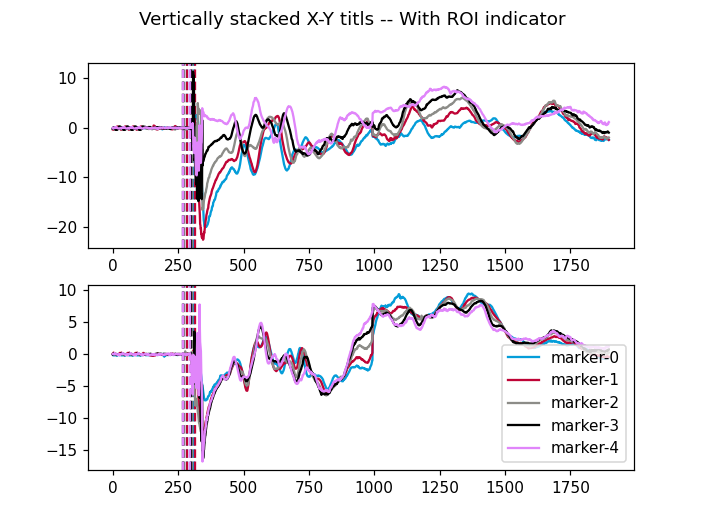

=> start frame for marker-0 is: 282
=> start frame for marker-1 is: 283
=> start frame for marker-2 is: 272
=> start frame for marker-3 is: 270
=> start frame for marker-4 is: 267
=> showing 2/5 signal


<IPython.core.display.Javascript object>


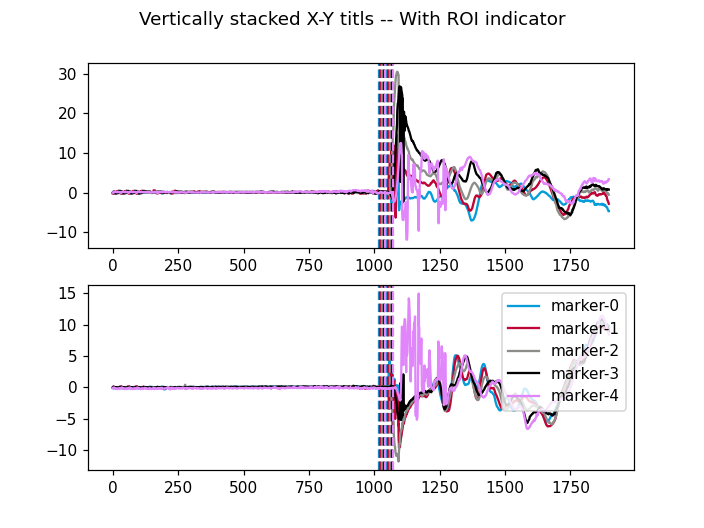

=> start frame for marker-0 is: 1020
=> start frame for marker-1 is: 1021
=> start frame for marker-2 is: 1029
=> start frame for marker-3 is: 1039
=> start frame for marker-4 is: 1042
=> showing 3/5 signal


<IPython.core.display.Javascript object>


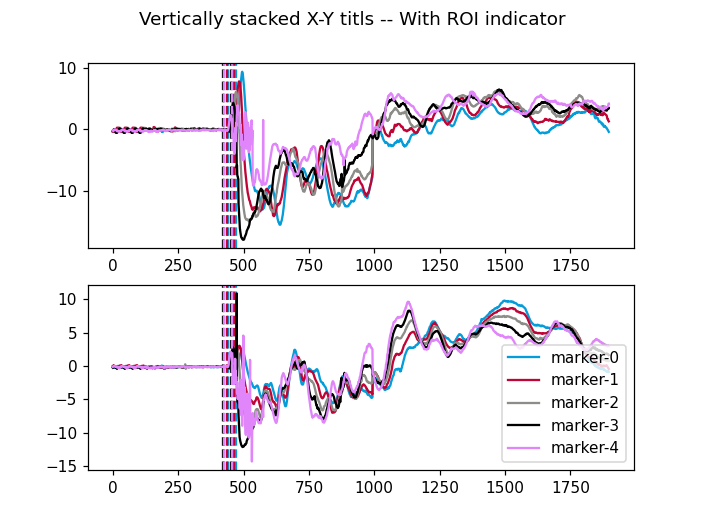

=> start frame for marker-0 is: 442
=> start frame for marker-1 is: 435
=> start frame for marker-2 is: 425
=> start frame for marker-3 is: 422
=> start frame for marker-4 is: 425
=> showing 4/5 signal


<IPython.core.display.Javascript object>


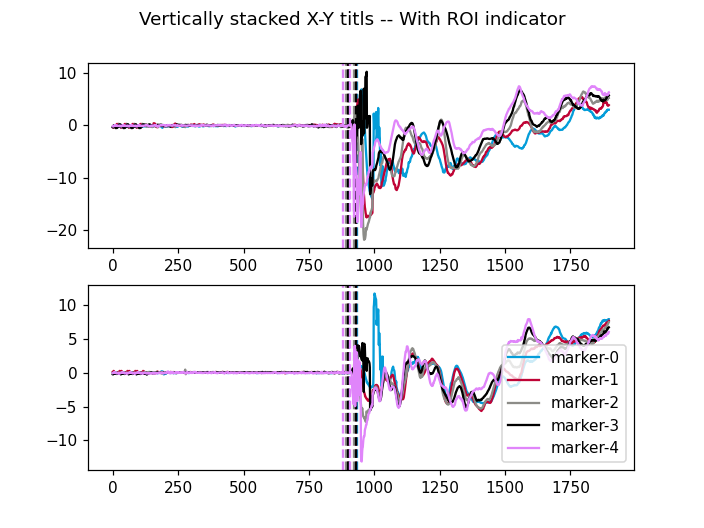

=> start frame for marker-0 is: 905
=> start frame for marker-1 is: 899
=> start frame for marker-2 is: 891
=> start frame for marker-3 is: 900
=> start frame for marker-4 is: 879
=> showing 5/5 signal


<IPython.core.display.Javascript object>


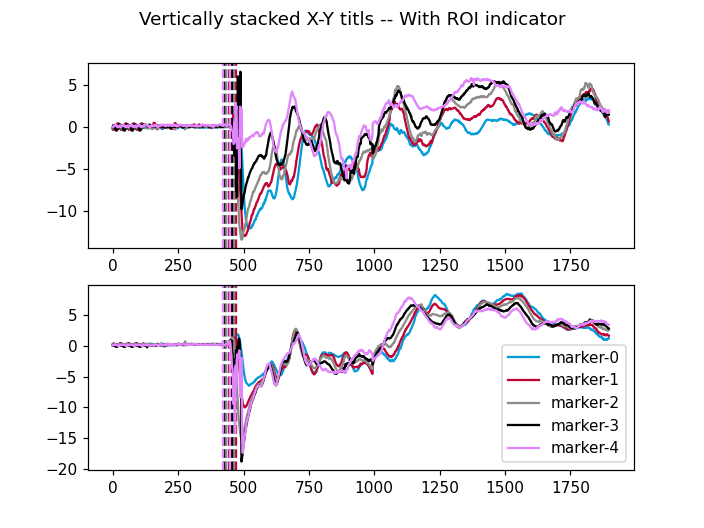

=> start frame for marker-0 is: 433
=> start frame for marker-1 is: 443
=> start frame for marker-2 is: 432
=> start frame for marker-3 is: 425
=> start frame for marker-4 is: 420


In [8]:
exp_index    = 0 # use this index parameter to specify measurements from which hit

marker_inds = [0, 1, 2, 3, 4]
m_location = [marker_locations[i] for i in marker_inds]

mar_names = ['marker-{}'.format(i) for i in marker_inds]
signal_list_list = all_signal_list_list

for _index in range(len(signal_list_list)):

    print("=> showing {}/{} signal".format(_index + 1, len(signal_list_list)))        
    signal_list = [signal_list_list[_index][_i] for _i in marker_inds]
    
    start_cfg = {
    'std_coe': 30.0, 'smoothing_wsize':8, 'forward_window_size': 40, 
    }

    pred_start_index_list = [
        signal_.get_start_index(**start_cfg) for signal_ in signal_list
                            ]

    plot_signals(signal_list, label_list=mar_names, 
                 start_index_list=pred_start_index_list, if_double_plot=False)

# exp_index    = 1
signal_list = [signal_list_list[exp_index][_i] for _i in marker_inds]

## Backprojection

In [9]:
# setting hyper-params for backprojection

drawing_cfg=dict(
    name="weighted_cone",
    fov=6,
    thickness=-1,
    weighting_by_scale=False, #'log', #'sqrt',
    weighting_by_uncertainty=False,
    cone_weighting=0.04,
)


proj_theta_cfg=dict(
            std_coe=30.0,
            smoothing_wsize=8,
            forward_window_size=40,
            if_normalize=False,
            start_index=-1,
            offset=20,
            thre=-1.0,
            window_size=120,
            stability_window_size=100, # this parameter is not used
            drawing_cfg=drawing_cfg,
            pre_size=10,
            safe_interval=10,
            # weighting_cfg={'name': 'poly', 'params': [1.0]}, 
            weighting_cfg={'name': 'exp'},
            global_start=False,
        )

marker_scaling = 12
# h,w 
board_size = np.array([ 
    corner_locations[0][1] - corner_locations[1][1], 
    corner_locations[1][0] - corner_locations[0][0], 
                      ] ) * marker_scaling
canvas_size = (board_size + 1.0).astype(np.int32)

# to centerize the markers 
marker_offset = (corner_locations[0] - np.array([-45.5, 45.5])) * -12
marker_offset = marker_offset.astype(np.int32)

proj_solver = BackProjSolver(m_location, marker_scaling=marker_scaling, canvas_size=canvas_size, 
                             angle_mapping_obj=angle_mapping_obj, theta_cfg=proj_theta_cfg, 
                            corner_locations=None, marker_offset=marker_offset)
    
save_path_ = os.path.join(dir_path, 'clip-{}.png'.format(exp_index))


[ 0.02417862 -0.02579716]
corner locations on canvas. tl. br
None


[283 283 273 271 267]


<IPython.core.display.Javascript object>


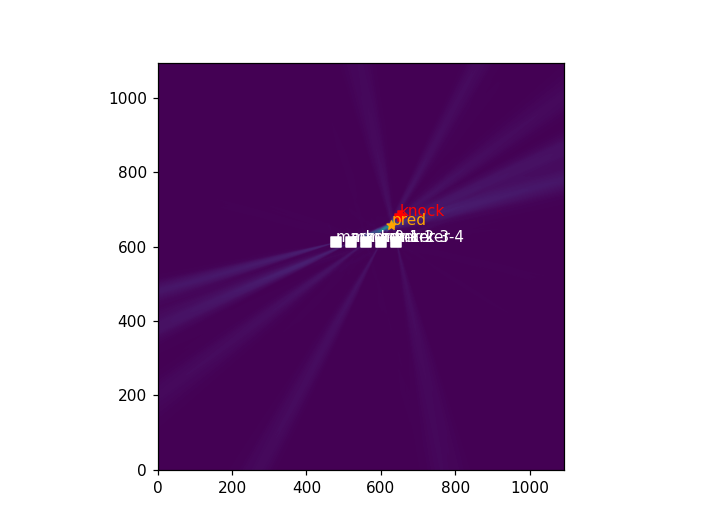

MSE: 2.72


In [10]:
def _main():
    pred_xy, heat_map = proj_solver.pred_and_plot(signal_list, gt_loc=gt_loc_list[exp_index], debug=True, 
                              start_index_list=None, )#save_path=save_path_) 
    return pred_xy, heat_map
pred_xy, heat_map = _main()


# note that gt_location in pingpong demos is not accurately annotated, 
#   due to motion blur and limited camera resolution
gt_loc = gt_loc_list[exp_index]

mse = np.sqrt( ((gt_loc - pred_xy) ** 2).sum())
print('MSE: {:.2f}'.format(mse))


## Blend the results with side-camera for visualization

This cell would perform homography to transform the backprojected heatmap and overlap it with the side-camera viewpoint for visualization

In [11]:
# heat_map, rgb_frame, canvas_size
bgr_frame = hit_frames[exp_index]
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

tmp_heatmap = heat_map
if 1:
    tmp_heatmap = heat_map[::-1, :]
    
# renorm to 0-255
tmp_heatmap = np.clip(tmp_heatmap, a_min=0, a_max=None)

tmp_heatmap = tmp_heatmap / np.max(tmp_heatmap) * 255.0

tmp_heatmap = np.clip(tmp_heatmap, a_min=0, a_max=255.0)


# perform homography to align viewpoints
heatmap_pxy = np.array([
    [0.0, 0.0],
    [0.0, canvas_size[0] * 1.0], 
    [canvas_size[1] * 1.0, 0.0],
    [canvas_size[1] * 1.0, canvas_size[0] * 1.0],
], dtype=np.float32)


M_inv = cv2.getPerspectiveTransform(heatmap_pxy, homo_rawxy.astype(np.float32))
raw_img_size = (1920, 1080)
# raw_img_size = (1080, 1920)
reprojected_heatmap = cv2.warpPerspective(tmp_heatmap, M_inv, raw_img_size)

# reprojected_heatmap = 255.0 * ((reprojected_heatmap / 255.0) ** 2.2)

cm_name = ['viridis', 'plasma', 'gnuplot'][1]
cm = plt.get_cmap(cm_name) # 'viridis', 'plasma'
# Apply the colormap like a function to any array:



colored_reproj_heatmap = cm(reprojected_heatmap / 255.0 )[:, :, :3]  # [0, 1] => [0, 1]
# gamma correction
# colored_reproj_heatmap = colored_reproj_heatmap ** 2.2
colored_reproj_heatmap = (colored_reproj_heatmap * 255.0).astype(np.uint8)


alpha_blend_ratio = 0.75
alpha_blend_mask = (np.mean(colored_reproj_heatmap, axis=-1) > (np.mean(colored_reproj_heatmap) * 2.5)).astype(np.float32)

# blended_image = colored_reproj_heatmap * alpha_blend_mask[:, :, np.newaxis] + rgb_frame
blended_image = colored_reproj_heatmap * alpha_blend_mask[:, :, np.newaxis] * alpha_blend_ratio + rgb_frame * alpha_blend_mask[:, :, np.newaxis] * (1- alpha_blend_ratio) + alpha_blend_ratio + rgb_frame * ( 1.0 - alpha_blend_mask[:, :, np.newaxis])

blended_image = np.clip(blended_image, 0, 255.0).astype(np.int32)
blended_image = np.clip(blended_image, 0, 255.0).astype(np.int32)



<IPython.core.display.Javascript object>


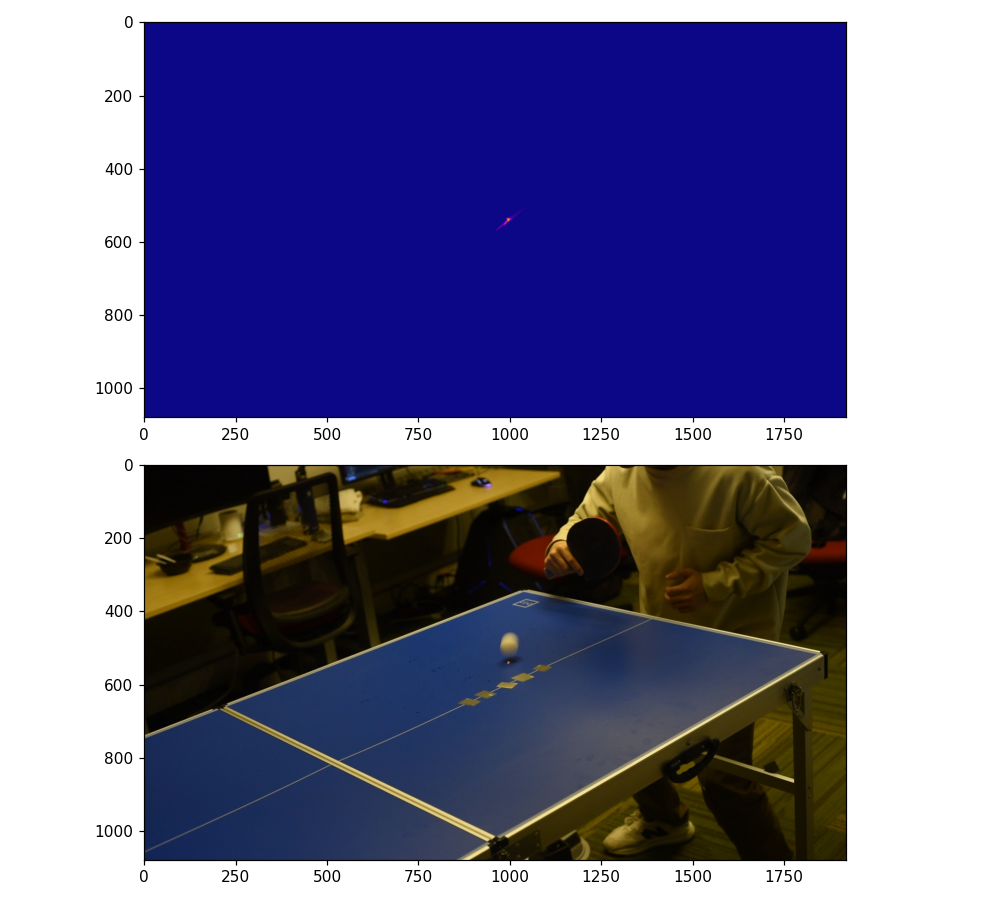

In [12]:
fig = plt.figure(tight_layout=True, figsize=(9, 8.2))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])

# plotting the transformed heatmap
# plotting the overlapped results

ax0.imshow(colored_reproj_heatmap)
ax1.imshow(blended_image)
plt.show()